# Обработка пропусков и выбросов в процессе первичного анализа статистики

### Disclaimer: 
_Представленные ниже примеры предназначены исключительно для демонстрации подходов к устранению аномалий в данных. Выбор подхода в "боевых условиях" должен осуществляеться в соответсвии с решаемыми задачами и с учетом особенностей формирования данных в исследуемом процессе_

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Загрузка датасета

In [2]:
data = pd.read_csv("iris.csv")
data.tail(7)

,sepal.length,sepal.width,petal.length,petal.width,variety
143,6.8,3.2,5.9,2.3,Virginica
144,6.7,3.3,5.7,2.5,Virginica
145,6.7,3.0,5.2,2.3,Virginica
146,6.3,2.5,5.0,1.9,Virginica
147,6.5,3.0,5.2,2.0,Virginica
148,6.2,3.4,5.4,2.3,Virginica
149,5.9,3.0,5.1,1.8,Virginica


### Добавляем немного NaN

In [3]:
data["petal.width"].iloc[145:149] = None
data.tail(7)

,sepal.length,sepal.width,petal.length,petal.width,variety
143,6.8,3.2,5.9,2.3,Virginica
144,6.7,3.3,5.7,2.5,Virginica
145,6.7,3.0,5.2,NaN,Virginica
146,6.3,2.5,5.0,NaN,Virginica
147,6.5,3.0,5.2,NaN,Virginica
148,6.2,3.4,5.4,NaN,Virginica
149,5.9,3.0,5.1,1.8,Virginica


## Построение гистограммы "petal.length"

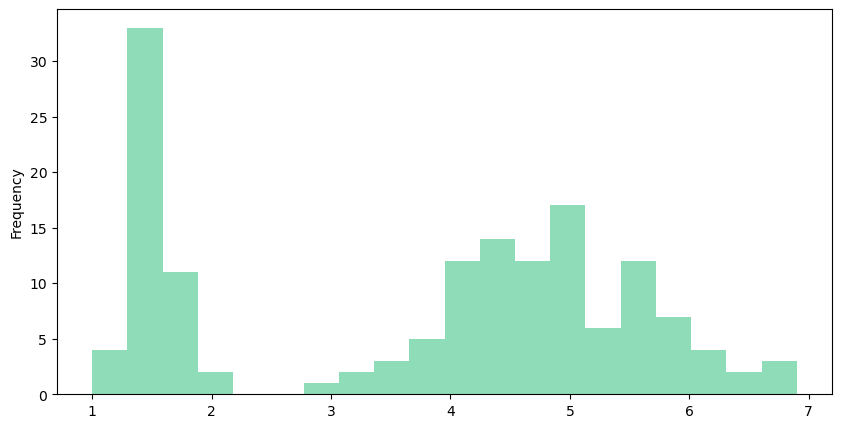

In [4]:
data["petal.length"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20 );

### Есть выброс "petal.length" в диапазоне примерно 1..1.9

### Зафиксируем исходные данные до заполнения NaN 

In [5]:
with_outliers = data["petal.length"].head(20).copy()
before_NaN = data["petal.width"].iloc[25:42].copy()

### Заменяем  выброс "petal.length" расчетными данными

#### длина лепестка не может быть отрицательной!

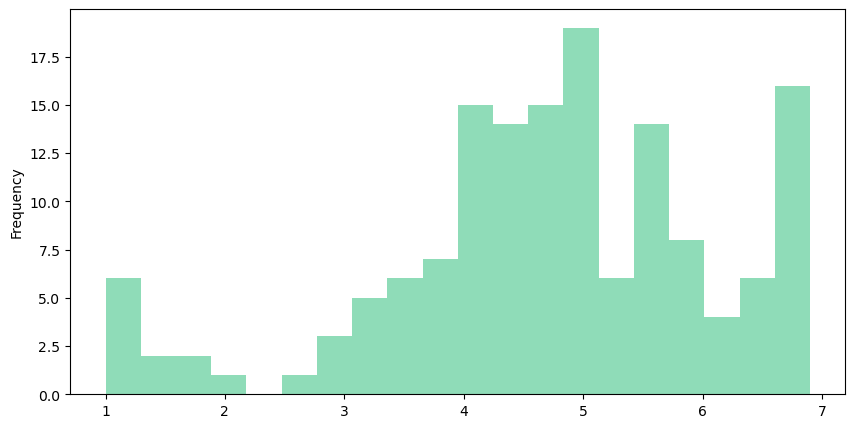

In [6]:
data["petal.length"][data["petal.length"]<=2.8] = np.clip(np.random.normal(loc= data["petal.length"][data["petal.length"]>=2.8].median(),
                                                        scale=data["petal.length"].var(), 
                                                        size=len(data["petal.length"][data["petal.length"]<=2.8])), 
                                                          data["petal.length"].min(),
                                                          data["petal.length"].max())
data["petal.length"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20 );

In [7]:
### снова выбросы :-(
### убираем выброс минимумов ...

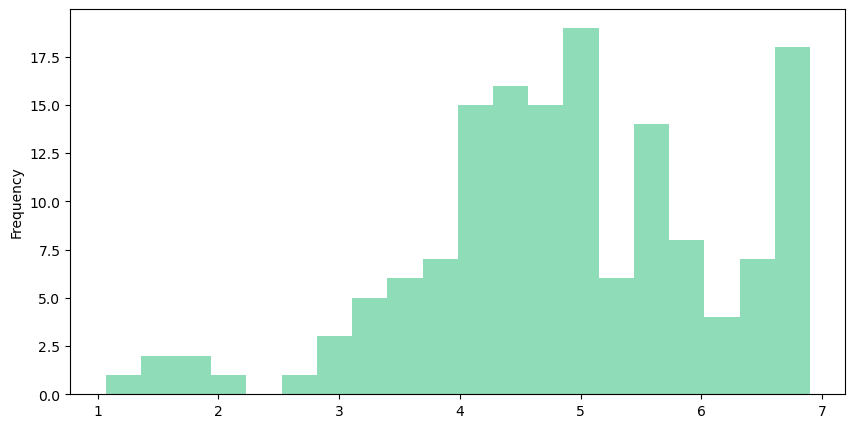

In [8]:
data["petal.length"][data["petal.length"]==data["petal.length"].min()] = np.clip(np.random.normal(loc= data["petal.length"].median(),
                                                        scale=data["petal.length"].var(), 
                                                        size=len(data["petal.length"][data["petal.length"]==data["petal.length"].min()]) ), 
                                                          data["petal.length"].min(),
                                                          data["petal.length"].max())



data["petal.length"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20 );

### ... и убираем выброс максимумов 

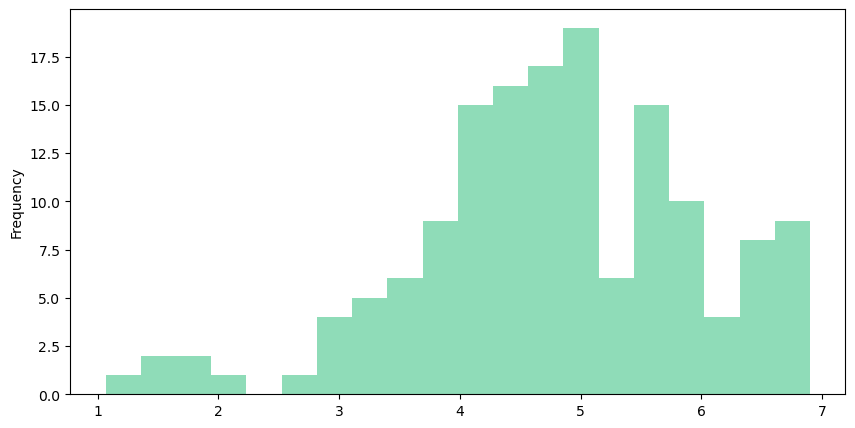

In [9]:
data["petal.length"][data["petal.length"]==data["petal.length"].max()] = np.clip(np.random.normal(loc= data["petal.length"].median(),
                                                        scale=data["petal.length"].var(), 
                                                        size=len(data["petal.length"][data["petal.length"]==data["petal.length"].max()]) ), 
                                                          data["petal.length"].min(),
                                                          data["petal.length"].max())
data["petal.length"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20 );

In [10]:
display(pd.DataFrame(list(zip(with_outliers, data["petal.length"].head(20))),
                   columns=["With_outliers", "After_norm"]))

,With_outliers,After_norm
0,1.4,1.827541
1,1.4,3.838343
2,1.3,3.693198
3,1.5,6.590381
4,1.4,4.494987
5,1.7,4.993769
6,1.4,6.376815
7,1.5,6.663713
8,1.4,2.929243
9,1.5,3.197798


###### Выброс исчез

## Построение гистограмы для "petal.width"

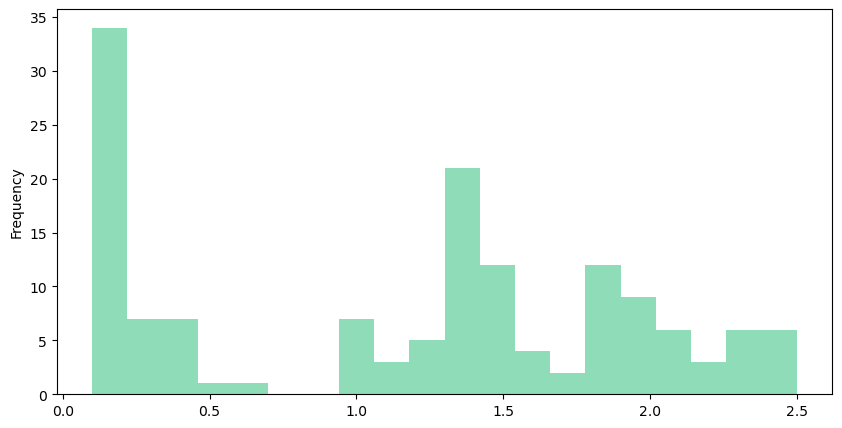

In [11]:
data["petal.width"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20 );

### убеждаемся в наличии NaN

In [12]:
data["petal.width"][data["petal.width"].isnull()]

145   NaN
146   NaN
147   NaN
148   NaN
Name: petal.width, dtype: float64

### Заполняем пропуски

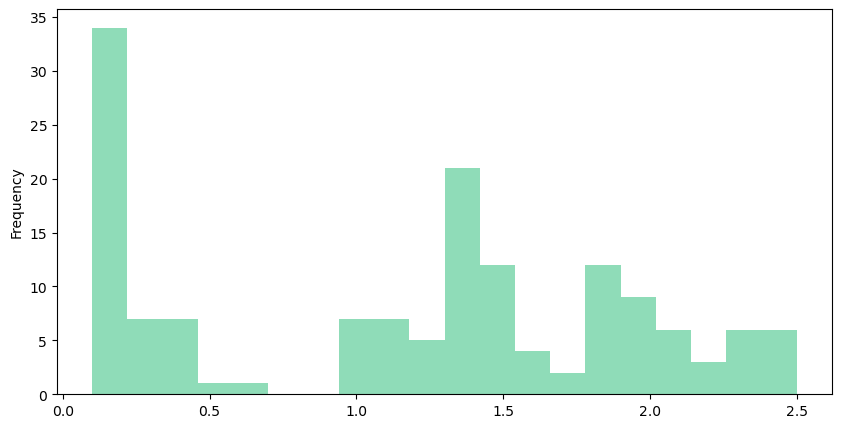

In [13]:
# используем std()
data["petal.width"].fillna(data["petal.width"].mean() 
                           + data["petal.width"].std()*np.random.randint(low=-1, high=2, size=1)[0], # ограничиваем отклонение
                          inplace=True)
data["petal.width"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20 );

In [14]:
data["petal.width"].tail(7)

143    2.300000
144    2.500000
145    1.173973
146    1.173973
147    1.173973
148    1.173973
149    1.800000
Name: petal.width, dtype: float64

### добавим еще пропусков (примерно 1/6)
### и проверим результаты по критерию $\chi^2$

array([21.,  5.,  5.,  1.,  1.,  0.,  0.,  7.,  7.,  5., 20., 11.,  3.,
        2.,  7.,  7.,  5.,  2.,  5.,  5.])

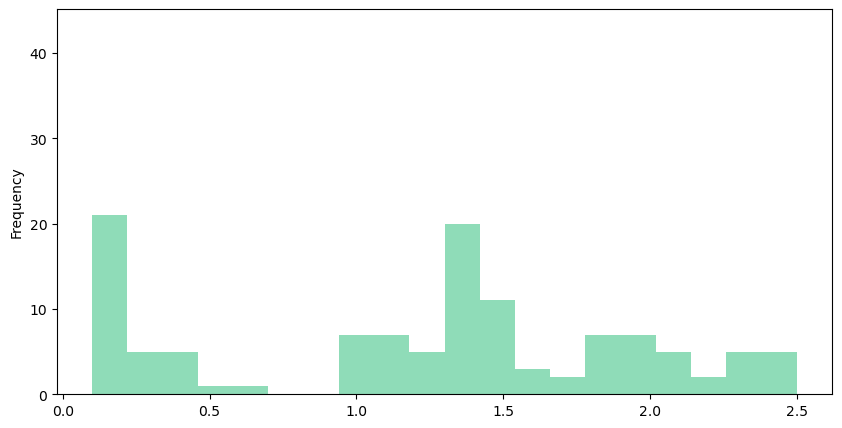

In [15]:
data["petal.width"].iloc[125:139] = None
data["petal.width"].iloc[25:42] = None
data["petal.width"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20 );

# фиксируем значения гистограммы (с разными BINS)
b_before, n_before, _ = plt.hist(data["petal.width"], bins=20, visible=False);
b2 = 5
b_before_2, n_before_2, _ = plt.hist(data["petal.width"], bins=b2, visible=False);

# значения столбиков гистограммы
b_before

In [16]:
data["petal.width"].iloc[25:42]

25   NaN
26   NaN
27   NaN
28   NaN
29   NaN
30   NaN
31   NaN
32   NaN
33   NaN
34   NaN
35   NaN
36   NaN
37   NaN
38   NaN
39   NaN
40   NaN
41   NaN
Name: petal.width, dtype: float64

### Подготовка корректирующих значений

In [17]:
df_corr = pd.DataFrame(np.random.normal(loc=data["petal.width"].mean(),
                                scale=data["petal.width"].var(), 
                                size=len(data["petal.width"])),
                      columns = ["petal.width"]) 
                                
df_corr                      

,petal.width
0,1.616743
1,1.668766
2,0.572870
3,1.163841
4,1.433937
...,...
145,0.757011
146,1.183449
147,0.772827
148,0.901743


In [18]:
df_corr.min() # больше нуля :-)

petal.width   -0.004842
dtype: float64

### Заполняем пропуски

In [19]:
data.fillna(value=df_corr, inplace=True)
display(pd.DataFrame(list(zip(before_NaN, data["petal.width"].iloc[25:42])),
                   columns=["before_set_NaN", "After_filling"]))

,before_set_NaN,After_filling
0,0.2,0.675680
1,0.4,1.253484
2,0.2,1.268283
3,0.2,-0.004842
4,0.2,1.642401
5,0.2,0.281174
6,0.4,1.066953
7,0.1,1.436001
8,0.2,0.531911
9,0.2,1.010252


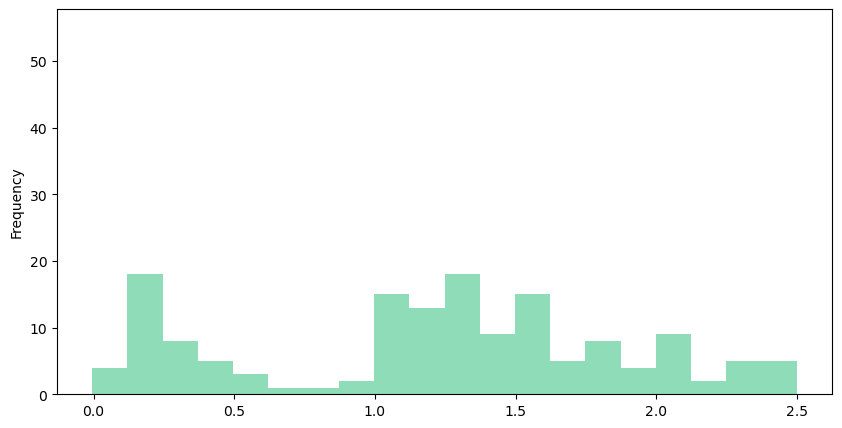

In [20]:
data["petal.width"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20, );
# получаем параметры гистограммы c bins = 20
b_after, n_after, _ = plt.hist(data["petal.width"], bins=20, visible=False);
# и bins = b2
b_after_2, n_after_2, _ = plt.hist(data["petal.width"], bins=b2, visible=False);

### Почти похоже на исходный :-)

#### ... но так ли это
#### используем критерий $\chi^2$

In [21]:
#!pip install scipy==1.6.3

In [22]:
import scipy
scipy.__version__

'1.6.3'

In [23]:
# сравниваем методом хи-квадрат
from scipy.stats import chisquare, chi2_contingency
print (f"ДО\n {b_before} \nПОСЛЕ\n {b_after}")
_, p_value = chisquare(b_before, b_after, ddof=len(b_after)-1)

print(f"p_value = {p_value}")

ДО
 [21.  5.  5.  1.  1.  0.  0.  7.  7.  5. 20. 11.  3.  2.  7.  7.  5.  2.
  5.  5.] 
ПОСЛЕ
 [ 4. 18.  8.  5.  3.  1.  1.  2. 15. 13. 18.  9. 15.  5.  8.  4.  9.  2.
  5.  5.]
p_value = nan


#### меняем bins

In [24]:
print (f"ДО\n {b_before_2} \nПОСЛЕ\n {b_after_2}")
#stat, p_value_2, dof, _= chi2_contingency([b_before_2, b_after_2])
_, p_value_2 = chisquare(b_before_2, b_after_2, ddof=len(b_after_2)-1)

print(f"p_value = {p_value_2}")

ДО
 [32.  8. 43. 19. 17.] 
ПОСЛЕ
 [35.  7. 55. 32. 21.]
p_value = nan


#### _...нужен иной подход ?_


### Снова генерируем пропуски, но в этот раз удаляем 

In [25]:
data["petal.width"].iloc[125:147] = None
data.tail(10)

,sepal.length,sepal.width,petal.length,petal.width,variety
140,6.7,3.1,5.6,NaN,Virginica
141,6.9,3.1,5.1,NaN,Virginica
142,5.8,2.7,5.1,NaN,Virginica
143,6.8,3.2,5.9,NaN,Virginica
144,6.7,3.3,5.7,NaN,Virginica
145,6.7,3.0,5.2,NaN,Virginica
146,6.3,2.5,5.0,NaN,Virginica
147,6.5,3.0,5.2,1.173973,Virginica
148,6.2,3.4,5.4,1.173973,Virginica
149,5.9,3.0,5.1,1.800000,Virginica


In [26]:
data.dropna(inplace=True)
data.tail(10)

,sepal.length,sepal.width,petal.length,petal.width,variety
118,7.7,2.6,6.9,2.300000,Virginica
119,6.0,2.2,5.0,1.500000,Virginica
120,6.9,3.2,5.7,2.300000,Virginica
121,5.6,2.8,4.9,2.000000,Virginica
122,7.7,2.8,6.7,2.000000,Virginica
123,6.3,2.7,4.9,1.800000,Virginica
124,6.7,3.3,5.7,2.100000,Virginica
147,6.5,3.0,5.2,1.173973,Virginica
148,6.2,3.4,5.4,1.173973,Virginica
149,5.9,3.0,5.1,1.800000,Virginica


### "Пропали" все строки с пропусками

## Заполняем смешанные пропуски
#### ...но сначала их создадим ))

In [27]:
display(data.head())
data.iloc[0:3] = None
display(data.head())

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.827541,0.2,Setosa
1,4.9,3.0,3.838343,0.2,Setosa
2,4.7,3.2,3.693198,0.2,Setosa
3,4.6,3.1,6.590381,0.2,Setosa
4,5.0,3.6,4.494987,0.2,Setosa


,sepal.length,sepal.width,petal.length,petal.width,variety
0,NaN,NaN,NaN,NaN,None
1,NaN,NaN,NaN,NaN,None
2,NaN,NaN,NaN,NaN,None
3,4.6,3.1,6.590381,0.2,Setosa
4,5.0,3.6,4.494987,0.2,Setosa


In [28]:
values = {"sepal.length": data["sepal.length"][data["variety"]=="Setosa"].mean(),
          "sepal.width": data["sepal.width"][data["variety"]=="Setosa"].mean(), 
          "petal.length": data["petal.length"][data["variety"]=="Setosa"].median(), 
          "petal.width": data["petal.width"][data["variety"]=="Setosa"].median(),
          "variety": "Setosa"}
data.fillna(value=values, inplace=True)
display(data.head())

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.012766,3.440426,4.642001,0.3,Setosa
1,5.012766,3.440426,4.642001,0.3,Setosa
2,5.012766,3.440426,4.642001,0.3,Setosa
3,4.600000,3.100000,6.590381,0.2,Setosa
4,5.000000,3.600000,4.494987,0.2,Setosa


## Extra case. Infinity

In [29]:
data["petal.width"].iloc[15:19] = np.array((np.inf, -np.inf, np.inf, np.log(0)))
data.iloc[15:19]

,sepal.length,sepal.width,petal.length,petal.width,variety
15,5.7,4.4,4.642001,inf,Setosa
16,5.4,3.9,1.065323,-inf,Setosa
17,5.1,3.5,4.751790,inf,Setosa
18,5.7,3.8,3.878122,-inf,Setosa


### Гистограмма не строится при наличии inf

In [30]:
data["petal.width"].describe()

count    128.000000
mean            NaN
std             NaN
min            -inf
25%        0.475000
50%        1.300000
75%        1.656413
max             inf
Name: petal.width, dtype: float64

In [31]:
data["petal.width"].plot.hist( figsize=(10,5), 
                color='#21BA72', alpha=0.5, bins=20 );
# Ой! Что-то пойшло не так!

ValueError: autodetected range of [-inf, inf] is not finite

## Заменяем inf и -inf на NaN

In [32]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.iloc[14:20]

,sepal.length,sepal.width,petal.length,petal.width,variety
14,5.8,4.0,4.616821,0.2,Setosa
15,5.7,4.4,4.642001,NaN,Setosa
16,5.4,3.9,1.065323,NaN,Setosa
17,5.1,3.5,4.751790,NaN,Setosa
18,5.7,3.8,3.878122,NaN,Setosa
19,5.1,3.8,3.433020,0.3,Setosa


### а дальше дело техники...

# Устранение пропусков в линиях/рядах

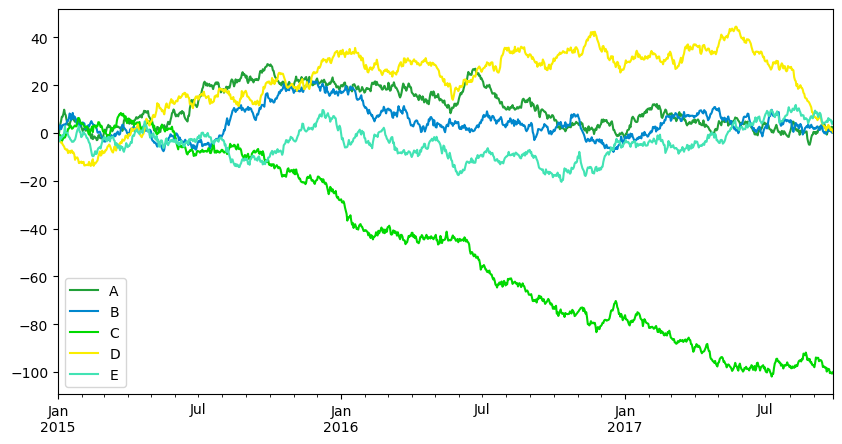

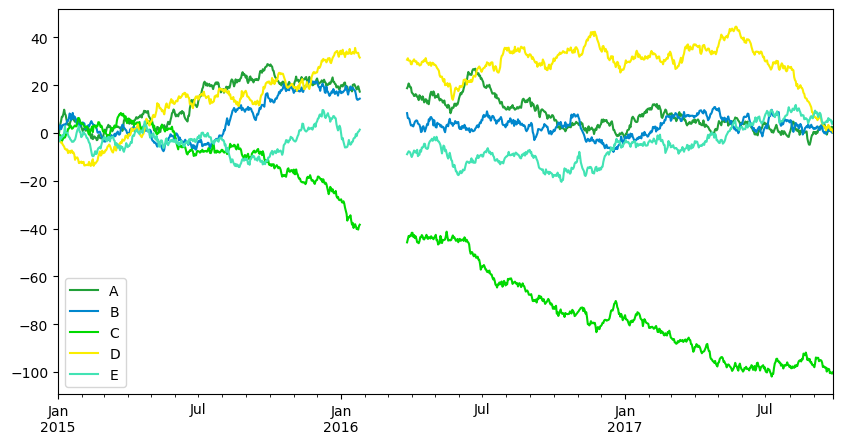

In [33]:
sbercolors = ['#21A038','#0087CD','#00D900', '#FAED00',  '#42E3B4','#21BA72'] 
image_params = dict(figsize=(10,5), 
                color=sbercolors)
samples = np.random.randn(1000, 5)

df = pd.DataFrame(samples, 
                   index=pd.date_range("1/1/2015", periods=1000),
                   columns=list("ABCDE"))
df = df.cumsum()
df.plot(**image_params);    
before = df.iloc[400:420].copy()        
df.iloc[390:450] = None

df.plot(**image_params);
  

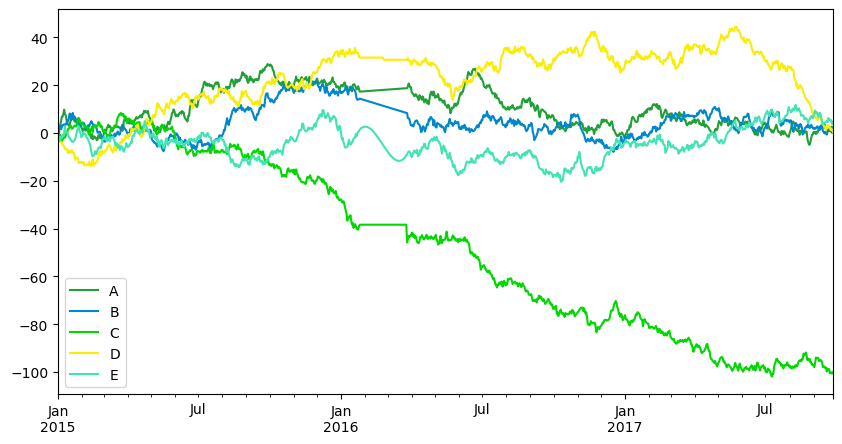

In [34]:
to_fill = {"A": df["A"].interpolate(method='linear'),
           "B": df["B"].interpolate(method='time'),
           "C": df["C"].interpolate(method='pad'),
           "D": df["D"].interpolate(method='nearest'),
           "E": df["E"].interpolate(method='akima'),}
df.fillna(value=to_fill, inplace=True)
df.plot(**image_params);


In [35]:
to_check = pd.concat((before,df.iloc[400:420]), axis=1)
to_check.columns = pd.MultiIndex.from_product([['Before', 'Recycled'], df.columns,],
                                     names=['subject', 'type'])

display(to_check) 

subject        Before                                             Recycled  \
type                A         B          C          D         E          A   
2016-02-05  18.595420  8.091847 -42.815323  25.347736 -3.285927  17.572417   
2016-02-06  18.454872  9.702521 -41.897166  26.355621 -4.898116  17.596182   
2016-02-07  18.047065  8.615967 -42.977221  27.287762 -4.246331  17.619946   
2016-02-08  17.460895  8.156147 -43.925581  27.470233 -5.345181  17.643711   
2016-02-09  19.833549  7.295351 -42.725734  26.661384 -4.996456  17.667475   
2016-02-10  21.040162  7.525921 -43.251658  26.437132 -6.380668  17.691240   
2016-02-11  20.782830  6.393164 -44.511085  27.395048 -3.823874  17.715004   
2016-02-12  20.453193  5.711717 -43.382491  27.393747 -2.135957  17.738769   
2016-02-13  21.433119  4.881444 -43.363406  29.202717 -0.633050  17.762533   
2016-02-14  21.576198  6.056551 -43.072263  28.673945 -1.309756  17.786298   
2016-02-15  20.040876  6.292727 -41.523289  28.800389 -1.128914  17.810062   
2016-02-16  21.407255  7.129201 -42.396297  30.673088 -1.004212  17.833827   
2016-02-17  20.355190  7.343865 -42.876476  29.167909 -1.676392  17.857591   
2016-02-18  20.092655  6.770801 -40.904157  27.318241  0.088303  17.881356   
2016-02-19  19.949149  7.500821 -41.951260  26.226127  0.403905  17.905120   
2016-02-20  19.414401  7.390955 -41.122800  26.315530  0.531355  17.928885   
2016-02-21  19.962479  8.437671 -40.553935  26.016002  0.634586  17.952649   
2016-02-22  18.596817  9.370972 -39.541817  24.863764  0.683459  17.976414   
2016-02-23  18.136705  9.045254 -40.815239  24.259579  1.367096  18.000178   
2016-02-24  18.362551  9.371559 -41.680320  25.011890  1.525673  18.023943   

subject                                                
type                B          C          D         E  
2016-02-05  13.287569 -38.361477  31.556251  2.345137  
2016-02-06  13.188167 -38.361477  31.556251  2.166103  
2016-02-07  13.088765 -38.361477  31.556251  1.951972  
2016-02-08  12.989362 -38.361477  31.556251  1.704823  
2016-02-09  12.889960 -38.361477  31.556251  1.426733  
2016-02-10  12.790557 -38.361477  31.556251  1.119782  
2016-02-11  12.691155 -38.361477  31.556251  0.786046  
2016-02-12  12.591753 -38.361477  31.556251  0.427604  
2016-02-13  12.492350 -38.361477  31.556251  0.046535  
2016-02-14  12.392948 -38.361477  31.556251 -0.355084  
2016-02-15  12.293546 -38.361477  31.556251 -0.775174  
2016-02-16  12.194143 -38.361477  31.556251 -1.211658  
2016-02-17  12.094741 -38.361477  31.556251 -1.662456  
2016-02-18  11.995338 -38.361477  31.556251 -2.125492  
2016-02-19  11.895936 -38.361477  31.556251 -2.598686  
2016-02-20  11.796534 -38.361477  31.556251 -3.079961  
2016-02-21  11.697131 -38.361477  31.556251 -3.567239  
2016-02-22  11.597729 -38.361477  31.556251 -4.058441  
2016-02-23  11.498327 -38.361477  31.556251 -4.551489  
2016-02-24  11.398924 -38.361477  31.556251 -5.044305

#### Проверим точность восстановления по критерию $\chi^2$

In [36]:
for litera in "ABCDE":
    stat, p_value = chisquare([to_check["Before", litera].abs(),  ## Только положительные заначения!!!
                               to_check["Recycled",litera].abs()])
    display(f"{litera}: {np.mean(p_value)}") 

'A: 0.7603479385418848'

'B: 0.3086477083921349'

'C: 0.6672332488621411'

'D: 0.5623848527953577'

'E: 0.34934026865951257'

#### или просто посчитаем погрешность

In [37]:
# set colors for min, max. average values
color_set = pd.DataFrame({"Colors":("MAX", "MIN", "AVERAGE")})

def highlight_fill(s):
    colors =  ['background-color: #42E3B4',
            'background-color: #0087CD',
             'background-color: #FAED00']
    return [colors[0] if i==0 else  colors[1] if i==1 else colors[2] for i in range(len(s))]


color_set = color_set.style.apply(highlight_fill)
display(color_set)

# count accurancy values

accurancy = pd.concat( (before-df.iloc[400:420],
                       pow((before-df.iloc[400:420]),2)), axis=1) 
accurancy.columns = pd.MultiIndex.from_product([['ABS', 'SQR'], df.columns,],
                                     names=['subject', 'type'])
# adding a row
accurancy.loc[-1] = [accurancy[a_s].mean() for a_s in accurancy.columns[:5].tolist()] +\
                    [np.sqrt(accurancy[a_s].sum()/(len(accurancy)-1)) for a_s in accurancy.columns[5:].tolist()]  

def highlight_diff_max(s):
    if max(abs(s))==max(s): 
        idx = s.tolist().index(max(abs(s)))
    elif max(abs(s))!=max(s):
        idx = s.tolist().index(max(s))
    return ['background-color: #42E3B4' if i==idx else '' for i in range(len(s))]

def highlight_diff_min(s):
    if min(abs(s))==min(s): 
        idx = s.tolist().index(min(abs(s)))
    elif min(abs(s))!=min(s):
        idx = s.tolist().index(min(s))
    return ['background-color: #0087CD' if i==idx else '' for i in range(len(s))]

def highlight_last_row(s):
    return ['background-color: #FAED00' if i==len(s)-1 else '' for i in range(len(s))]

accurancy = accurancy.style.apply(highlight_last_row).apply(highlight_diff_max).apply(highlight_diff_min)
accurancy


,Colors
0,MAX
1,MIN
2,AVERAGE


### Красиво сохраняем...

In [38]:
type(accurancy)

pandas.io.formats.style.Styler

In [39]:
accurancy.to_excel("accurancy.xlsx") # xlsx only !!!!!!!!